In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from pickle import dump

In [41]:
df = pd.read_csv("../data/train.csv")

In [42]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Пропущенные значения

In [44]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [45]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


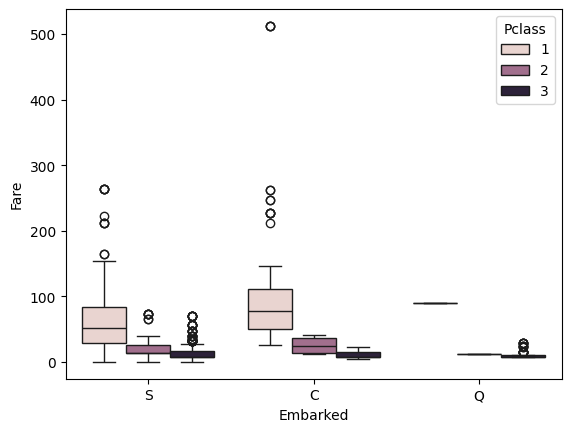

In [46]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=df);

In [47]:
df["Embarked"] = df["Embarked"].fillna('C')

Конвертация категориальных переменных

In [48]:
cat_features=['Embarked', 'Sex', 'SibSp', 'Parch', 'Pclass']
cat_transformer = Pipeline(
    steps=[
        ("onehot-encoder", OneHotEncoder(drop="first", 
                                         handle_unknown="ignore")),
    ]
)

In [49]:
# #predicting missing values in age using Random Forest
# class AgeImputer():
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         df = X.copy()
#         #Feature set
#         age_df = df[['Age', 'Sex', 'Embarked', 'Fare', 'Parch', 'SibSp', 'Pclass']]
#         # Split sets into df and test
#         train  = age_df.loc[df.Age.notnull()]# known Age values
#         test = age_df.loc[df.Age.isnull()]# null Ages
        
#         # All age values are stored in a target array
#         Y_train = train['Age']
        
#         # All the other values are stored in the feature array
#         X_train = train.drop(columns=['Age'])
        
#         # Create and fit a model
#         rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
#         rtr.fit(X_train, Y_train)
        
#         # Use the fitted model to predict the missing values
#         predicted_ages = rtr.predict(test.drop(columns=['Age']))
        
#         # Assign those predictions to the full data set
#         df.loc[df.Age.isnull(), 'Age'] = predicted_ages 
#         df.reset_index(drop=True, inplace=True)
        
#         return df

In [50]:
# age_transform = Pipeline(
#     steps=[
#         ("age_imputer", AgeImputer()),
#         ]
# )

In [51]:
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

Модель

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        # ("age", age_transform, ["Age"]),
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", cat_transformer, cat_features),
    ]
)

In [53]:
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regressor", LogisticRegression())
    ]
)

In [54]:
train, test = train_test_split(df, test_size=0.3)

In [55]:
predictors = numeric_features + cat_features
target = "Survived"

X_train = train[predictors]
X_test = test[predictors]

Y_train = train[target]
Y_test = test[target]

In [56]:
pipe.fit(X_train, Y_train)

predictions = pipe.predict(X_test)
probabilities = pipe.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)
roc_auc = roc_auc_score(Y_test, probabilities)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.8059701492537313
Precision: 0.71875
Recall: 0.7340425531914894
F1 Score: 0.7263157894736842
ROC AUC Score: 0.8606933235509904


In [58]:
Path("../models").mkdir(parents=True, exist_ok=True)

with open("../models/pipeline.pkl", "wb") as file:
    dump(pipe, file)